# 그룹과제-4: 트랜잭션 데이터로부터 의미있는 피처(feature) 만들기
- **Input**: transactions.csv (트랜잭션 형식의 판매 데이터)
- **Output**: features.csv (머신러닝 모델링이 가능한 형태의 고객 feature 데이터, 일명 *Customer Signature*)  

<span style="color:blue">**아래 코드를 참고하여 과제를 수행한 노트북화일(.ipynb)을 기한 내에 가상대학에 제출하기 바랍니다.**</span>  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

pd.set_option('max_columns', 20, 'max_rows', 20)

In [2]:
# 차트에서 한글 출력을 위한 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

## Read Transactions

In [3]:
tr = pd.read_csv('transactions.csv', encoding='cp949')
tr

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000
...,...,...,...,...,...,...,...
231999,3499,2007-12-17 00:00:00,본 점,127129,상품군미지정,기타,-135000
232000,3499,2007-12-23 00:00:00,노원점,285136,시티웨어,시티웨어,6380000
232001,3499,2007-12-23 00:00:00,노원점,39107,야채,농산물,40800
232002,3499,2007-12-27 00:00:00,본 점,740120,어덜트,명품,4880000


## Feature Generation

*새로 만든 feature와 병합할 고객ID로만 이루어진 데이터프레임을 만든다.*

In [4]:
features = pd.DataFrame({'cust_id': tr.cust_id.unique()})

<br><font color='green'>
### Numeric Features

**[파생변수 1-4]** 총구매액, 구매건수, 평균구매액, 최대구매액

In [5]:
f = tr.groupby('cust_id')['amount'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액
0,0,68282840,74,922741,11264000
1,1,2136000,3,712000,2136000
2,2,3197000,4,799250,1639000
3,3,16077620,44,365400,4935000
4,4,29050000,3,9683333,24000000
...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900
3496,3496,29628600,13,2279123,7200000
3497,3497,75000,1,75000,75000
3498,3498,1875000,2,937500,1000000


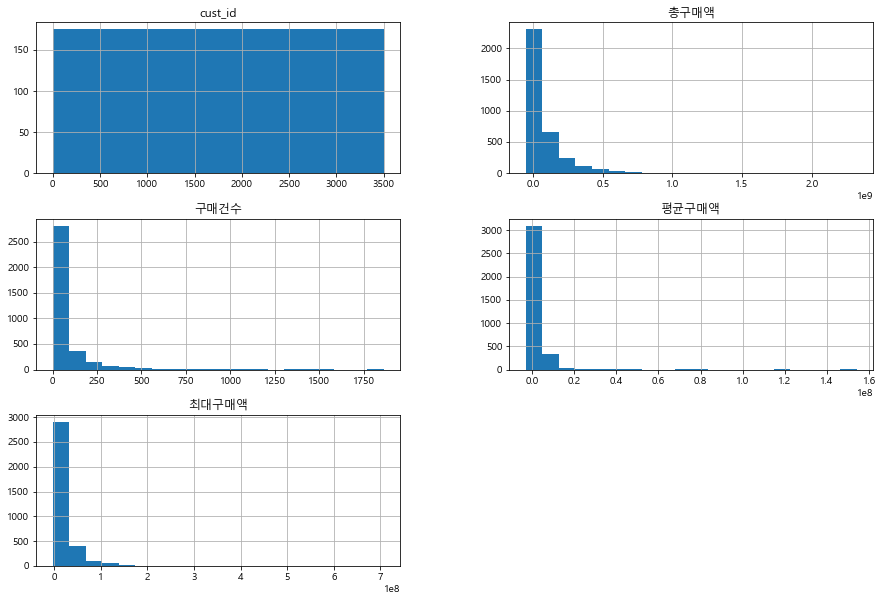

In [6]:
# histogram
f.hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 5-7]** 구매상품종류(goods_id, gds_grp_nm, gds_grp_mclas_nm 각각)

In [7]:
f = tr.groupby('cust_id').agg({
    'goods_id': [('구매상품종류1', lambda x: x.nunique())],
    'gds_grp_nm': [('구매상품종류2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('구매상품종류3', lambda x: x.nunique())]
})

f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
f=f.reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3
0,0,68282840,74,922741,11264000,35,28,17
1,1,2136000,3,712000,2136000,2,2,2
2,2,3197000,4,799250,1639000,1,2,2
3,3,16077620,44,365400,4935000,24,20,13
4,4,29050000,3,9683333,24000000,2,3,3
...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2
3496,3496,29628600,13,2279123,7200000,9,7,5
3497,3497,75000,1,75000,75000,1,1,1
3498,3498,1875000,2,937500,1000000,1,1,1


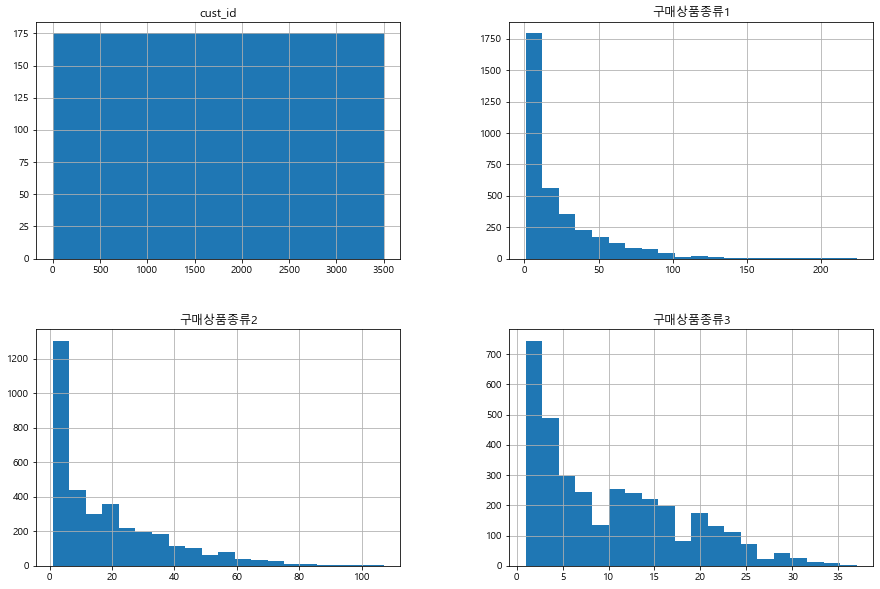

In [8]:
# histogram
f.hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 8-14]** 내점일수, 구매주기, 주말방문비율, 계절별 구매비율(Spring(3-5)/Summer(6-8)/Fall(9-11)/Winter(12-2))

In [9]:
f = tr.groupby('cust_id')['tran_date'].agg([
    ('내점일수',lambda x: x.str[:10].nunique()),
    ('구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique())),
    ('주말방문비율', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4)),
    ('봄-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([3,4,5]))),
    ('여름-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([6,7,8]))),
    ('가을-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([9,10,11]))),
    ('겨울-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([1,2,12])))
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000


**[파생변수 15-16]** 환불금액, 환불건수

In [10]:
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([
    ('환불금액', lambda x: x.sum() * -1),
    ('환불건수', np.size)
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615,6049600.0,1.0
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000,NaN,NaN


**[파생변수 17-18]** 내점 당 구매액, 구매건수

In [11]:
# 내점 당 구매액 = 총구매액 / 내점일수
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique())
f = (tr.groupby('cust_id')['amount'].sum() / visits).reset_index().rename(columns={0 : "내점당구매액"})
features = features.merge(f, how='left'); features
f = (tr.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "내점당구매건수"})
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,여름-구매비율,가을-구매비율,겨울-구매비율,환불금액,환불건수,내점당구매액,내점당구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,0.527027,0.094595,0.391892,0.378378,0.135135,6860000.0,3.0,3.593834e+06,3.894737
1,1,2136000,3,712000,2136000,2,2,2,2,1,0.000000,0.000000,0.000000,1.000000,0.000000,300000.0,1.0,1.068000e+06,1.500000
2,2,3197000,4,799250,1639000,1,2,2,2,1,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,1.598500e+06,2.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,0.318182,0.590909,0.159091,0.113636,0.136364,NaN,NaN,8.932011e+05,2.444444
4,4,29050000,3,9683333,24000000,2,3,3,2,85,0.000000,0.333333,0.000000,0.666667,0.000000,NaN,NaN,1.452500e+07,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,3.175200e+06,2.000000
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,0.461538,0.076923,0.076923,0.461538,0.384615,6049600.0,1.0,3.703575e+06,1.625000
3497,3497,75000,1,75000,75000,1,1,1,1,0,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,7.500000e+04,1.000000
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,0.000000,0.500000,0.000000,0.000000,0.500000,NaN,NaN,9.375000e+05,1.000000


**[파생변수 19-24]** 최근 3개월, 6개월, 12개월 구매금액 및 구매건수

In [12]:
# pd.to_datetime(), pd.offsets.MonthBegin(3)
for m in [3,6,12]:
    start = str(pd.to_datetime(tr.tran_date.max()) - pd.offsets.MonthBegin(m))
    f = tr.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
        (f'최근{m}개월_구매금액', np.sum), 
        (f'최근{m}개월_구매건수', np.size)
    ]).reset_index()
    display(f)
    features = features.merge(f, how='left'); features

,cust_id,최근3개월_구매금액,최근3개월_구매건수
0,0,29084140,27
1,1,2136000,3
2,3,549620,4
3,4,27000000,2
4,7,140818200,36
...,...,...,...
2439,3492,9154000,1
2440,3493,42697460,101
2441,3494,82800000,2
2442,3496,12028000,7


,cust_id,최근6개월_구매금액,최근6개월_구매건수
0,0,42601240,61
1,1,2136000,3
2,3,1284060,11
3,4,27000000,2
4,6,2250000,2
...,...,...,...
2778,3492,9154000,1
2779,3493,59972640,140
2780,3494,82800000,2
2781,3496,19224000,11


,cust_id,최근12개월_구매금액,최근12개월_구매건수
0,0,68282840,74
1,1,2136000,3
2,2,3197000,4
3,3,16077620,44
4,4,29050000,3
...,...,...,...
3495,3495,3175200,2
3496,3496,29628600,13
3497,3497,75000,1
3498,3498,1875000,2


<br><font color='green'>
### Categorical Features

**[파생변수 25]** 주구매 상품: 가장 많이 구매한 상품(gds_grp_mclas_nm)

In [13]:
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,환불건수,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.0,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.0,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,1.598500e+06,2.000000,NaN,NaN,NaN,NaN,3197000,4,기타
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,NaN,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,NaN,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,화장품
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,NaN,3.175200e+06,2.000000,NaN,NaN,NaN,NaN,3175200,2,골프
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,1.0,3.703575e+06,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,NaN,7.500000e+04,1.000000,NaN,NaN,NaN,NaN,75000,1,주방용품
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,NaN,9.375000e+05,1.000000,NaN,NaN,NaN,NaN,1875000,2,화장품


<AxesSubplot:xlabel='count', ylabel='주구매상품'>

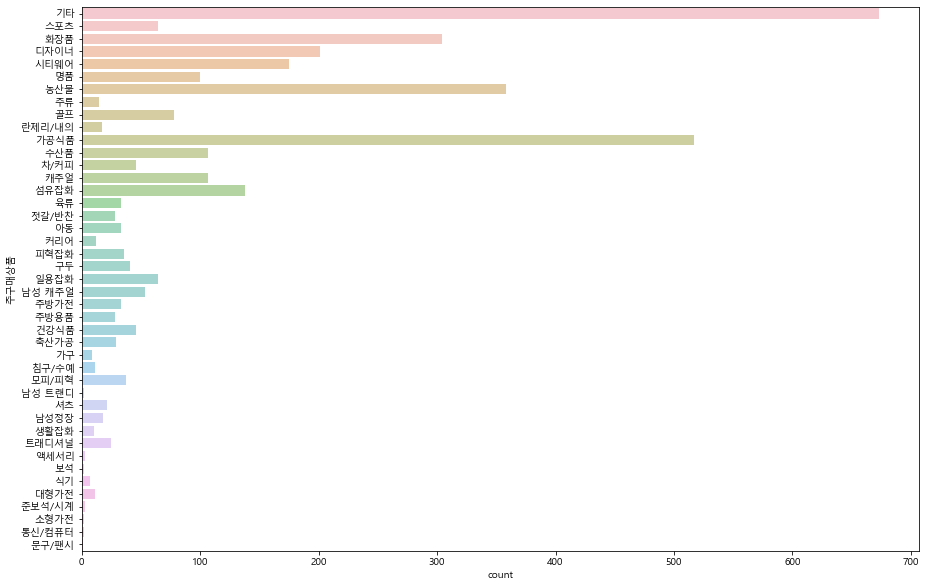

In [14]:
# 범주형 속성 값의 빈도 출력
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='주구매상품', data=f, alpha=0.5)

**[파생변수 26]** 주구매 지점

In [15]:
f = tr.groupby('cust_id')['store_nm'].agg([
    ('주구매지점', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left'); features

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,내점당구매액,내점당구매건수,최근3개월_구매금액,최근3개월_구매건수,최근6개월_구매금액,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,3.593834e+06,3.894737,29084140.0,27.0,42601240.0,61.0,68282840,74,기타,강남점
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,1.068000e+06,1.500000,2136000.0,3.0,2136000.0,3.0,2136000,3,스포츠,잠실점
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,1.598500e+06,2.000000,NaN,NaN,NaN,NaN,3197000,4,기타,관악점
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,8.932011e+05,2.444444,549620.0,4.0,1284060.0,11.0,16077620,44,기타,광주점
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,1.452500e+07,1.500000,27000000.0,2.0,27000000.0,2.0,29050000,3,화장품,본 점
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,3.175200e+06,2.000000,NaN,NaN,NaN,NaN,3175200,2,골프,본 점
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,3.703575e+06,1.625000,12028000.0,7.0,19224000.0,11.0,29628600,13,시티웨어,부산본점
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,7.500000e+04,1.000000,NaN,NaN,NaN,NaN,75000,1,주방용품,창원점
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,9.375000e+05,1.000000,NaN,NaN,NaN,NaN,1875000,2,화장품,본 점


<br><font color='red'>
**[파생변수 27-35]** 추가로 새로운 파생변수를 제안하고 구현해야 함! 아래는 예시.
- 구매추세 패턴
- 가격선호도 (예: 고가상품구매율)
- 시즌 선호도
- 휴면(또는 이탈) 여부
- Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부
- 상품별 구매순서
- 주구매 요일 

<br><font color='blue'>
## **[파생변수 27-35]** 구현한 파생변수
---------------------------------------
- 남성키워드 구매건수비율
- 여성키워드 구매건수비율
- 명품키워드 구매건수비율
- 행사키워드 구매건수비율
- 영키워드 구매건수비율
- 최다방문지점구매비율
- 공휴일 구매건수
- 행사성고객 여부
- 환불여부

**[파생변수 27-31]** [남성, 여성, 명품, 행사, 영] 키워드 구매건수비율

In [16]:
mclas_table = tr.pivot_table(index = 'cust_id', 
                             columns = 'gds_grp_mclas_nm', 
                             values = 'amount', 
                             aggfunc = 'count', 
                             fill_value = 0)

In [17]:
mclas_features = pd.DataFrame({'cust_id': tr.cust_id.unique()})

In [18]:
f_1 = mclas_table.filter(regex = '남성')
f_2 = mclas_table.filter(regex = '스포츠')
f_3 = mclas_table.filter(regex = '통신/컴퓨터')
f_4 = mclas_table.filter(regex = '아동')
f_5 = mclas_table.filter(regex = '화장품')
f_6 = mclas_table.filter(regex = '주방용품')
f_7 = mclas_table.filter(regex = '명품')

In [19]:
mclas_features = mclas_features.merge(f_1, left_on = 'cust_id', right_index = True)
mclas_features = mclas_features.merge(f_2, left_on = 'cust_id', right_index = True)
mclas_features = mclas_features.merge(f_3, left_on = 'cust_id', right_index = True)
mclas_features = mclas_features.merge(f_4, left_on = 'cust_id', right_index = True)
mclas_features = mclas_features.merge(f_5, left_on = 'cust_id', right_index = True)
mclas_features = mclas_features.merge(f_6, left_on = 'cust_id', right_index = True)
mclas_features = mclas_features.merge(f_7, left_on = 'cust_id', right_index = True)

#### 남성키워드 구매건수비율 - gds_grp_mcals_nm
주 구매고객이 남성일 것 같은 상품을 남성키워드로 지정
- 남성캐주얼
- 남성트랜디
- 남성정장
- 스포츠
- 통신/컴퓨터

In [20]:
# gds_grp_mclas_nm 에서 '남성', '스포츠', '통신/컴퓨터' 키워드 구매개수 합 / 전체구매개수
features['남성키워드구매건수비율'] = np.sum(mclas_features.iloc[:,1:6], axis = 1) / features['구매건수']

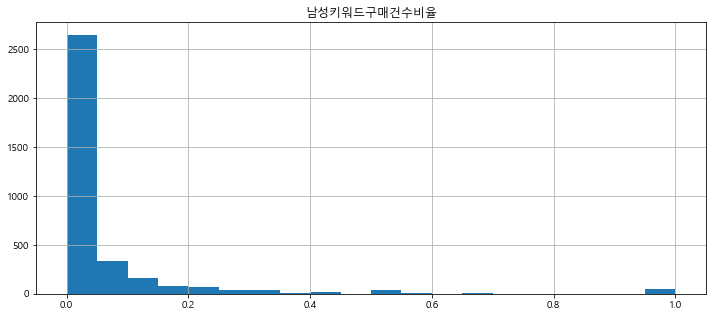

In [21]:
fig, ax = plt.subplots(figsize = (12,5))
features['남성키워드구매건수비율'].hist(bins = 20)
plt.title('남성키워드구매건수비율')
plt.show()

#### 여성키워드 구매건수비율 - gds_grp_mcals_nm
주구매고객이 여성일 것 같은 상품을 남성키워드로 지정
- 아동
- 화장품
- 주방용품

In [22]:
# gds_grp_mclas_nm 에서 '아동', '화장품', '주방용품' 키워드 구매개수 합 / 전체구매개수
features['여성키워드구매건수비율'] = np.sum(mclas_features.iloc[:,6:-1], axis = 1) / features['구매건수']

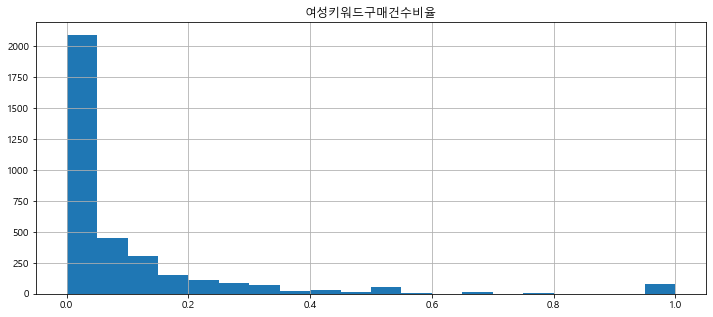

In [23]:
fig, ax = plt.subplots(figsize = (12,5))
features['여성키워드구매건수비율'].hist(bins = 20)
plt.title('여성키워드구매건수비율')
plt.show()

#### 명품키워드 구매건수비율 - gds_grp_mcals_nm
- 명품을 구매하는 고객은 연령층이 높을 것

In [24]:
# gds_grp_mclas_nm 에서 '명품' 키워드 구매개수 합 / 전체구매개수
features['명품키워드구매건수비율'] = mclas_features.iloc[:,-1] / features['구매건수']

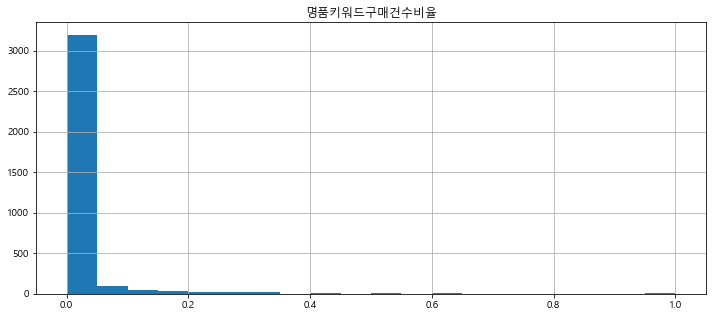

In [25]:
fig, ax = plt.subplots(figsize = (12,5))
features['명품키워드구매건수비율'].hist(bins = 20)
plt.title('명품키워드구매건수비율')
plt.show()

#### 행사키워드 구매건수비율 - gds_grp_nm
- 주로 여성이 구매할 것이라고 추측

In [26]:
# gds_grp_nm에서 '행사'키워드구매개수 / 전체구매건
f = tr[tr['gds_grp_nm'].str.contains('행사')].groupby('cust_id')['gds_grp_nm'].agg([('행사키워드구매개수', lambda x : x.count())]).reset_index()
features = features.merge(f, how = 'left')
features['행사키워드구매개수'].fillna(0, inplace = True)
features['행사키워드구매건수비율'] = features['행사키워드구매개수'] / features['구매건수']
features.drop('행사키워드구매개수',axis = 1, inplace = True)

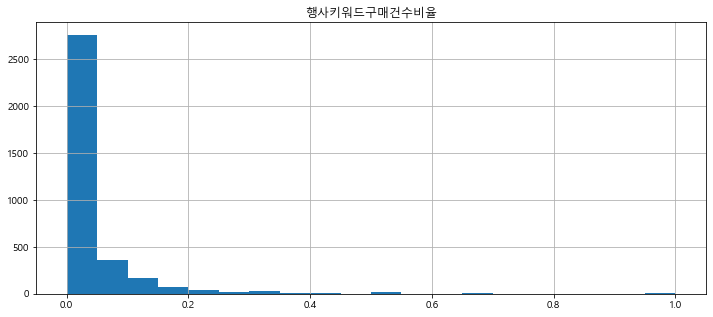

In [27]:
fig, ax = plt.subplots(figsize = (12,5))
features['행사키워드구매건수비율'].hist(bins = 20)
plt.title('행사키워드구매건수비율')
plt.show()

#### 영키워드 구매건수비율 - gds_grp_nm
주구매고객의 연령층이 낮을 것 같은 상품을 영키워드로 지정
- 영캐주얼, 영 캐릭터 영 트렌디, 영캐주얼행사, 영플라자(핸드백)
- 영플라자(이지), 영플라자(장신), 영플라자(영캐주얼), 영플라자(스트리트), 영플라자(진/유니)
- 영플라자(가방), 영플라자(패션), 영플라자(올리브핫스텁)

In [28]:
# gds_grp_nm에서 '영'키워드구매개수 / 전체구매개수
f = tr[tr['gds_grp_nm'].str.contains('영')].drop(tr[tr['gds_grp_nm'].str.contains('수영복')].index).groupby('cust_id')['gds_grp_nm'].agg([('영키워드구매개수', lambda x: x.count())]).reset_index()
features = features.merge(f, how = 'left')
features['영키워드구매개수'].fillna(0, inplace = True)

features['영키워드구매건수비율'] = features['영키워드구매개수'] / features['구매건수']

features.drop('영키워드구매개수',axis = 1, inplace = True)

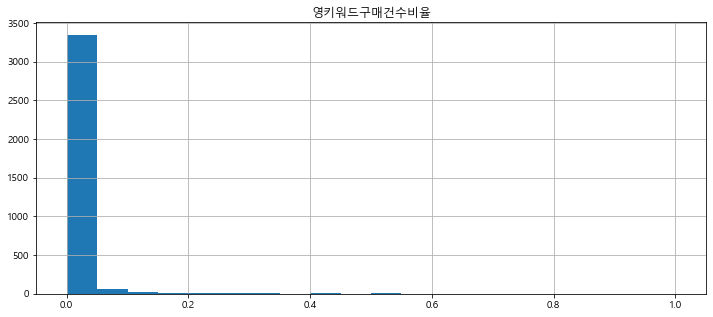

In [29]:
fig, ax = plt.subplots(figsize = (12,5))
features['영키워드구매건수비율'].hist(bins = 20)
plt.title('영키워드구매건수비율')
plt.show()

#### [남성, 여성, 명품, 행사, 영] 키워드 구매건수비율

In [30]:
features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최근6개월_구매건수,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,남성키워드구매건수비율,여성키워드구매건수비율,명품키워드구매건수비율,행사키워드구매건수비율,영키워드구매건수비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,61.0,68282840,74,기타,강남점,0.054054,0.094595,0.0,0.067568,0.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,3.0,2136000,3,스포츠,잠실점,0.666667,0.000000,0.0,0.000000,0.0
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,NaN,3197000,4,기타,관악점,0.500000,0.000000,0.0,0.000000,0.0
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,11.0,16077620,44,기타,광주점,0.000000,0.022727,0.0,0.000000,0.0
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,2.0,29050000,3,화장품,본 점,0.000000,0.333333,0.0,0.000000,0.0


**[파생변수 32]** 최다방문지점구매비율

#### 최다방문지점구매비율 - store_nm
피처 선정 이유 : 젊은 층은 비교적 여러 지점을 방문하고 고령층은 젊은 층에 비해 비교적 한 지점을 더 많이 갈 것이라고 가정
- 제일 많이가는 지점 / 전체 방문수

In [31]:
# 제일 많이가는 지점 / 전체 방문수
store_table = tr.pivot_table(index = 'cust_id', columns = 'store_nm', values = 'amount', aggfunc = 'count', fill_value = 0, margins = True)
f = (store_table.iloc[:-1, :-1].max(axis = 1) / store_table['All'].iloc[:-1]).reset_index()
features['최다방문지점구매비율'] = f[0]

In [32]:
features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최근12개월_구매금액,최근12개월_구매건수,주구매상품,주구매지점,남성키워드구매건수비율,여성키워드구매건수비율,명품키워드구매건수비율,행사키워드구매건수비율,영키워드구매건수비율,최다방문지점구매비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,68282840,74,기타,강남점,0.054054,0.094595,0.0,0.067568,0.0,0.959459
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,2136000,3,스포츠,잠실점,0.666667,0.000000,0.0,0.000000,0.0,1.000000
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,3197000,4,기타,관악점,0.500000,0.000000,0.0,0.000000,0.0,1.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,16077620,44,기타,광주점,0.000000,0.022727,0.0,0.000000,0.0,1.000000
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,29050000,3,화장품,본 점,0.000000,0.333333,0.0,0.000000,0.0,1.000000


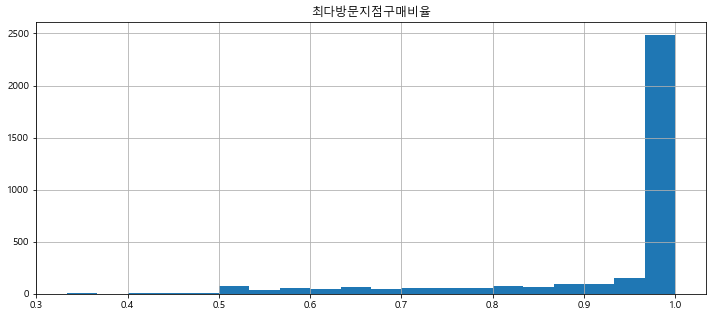

In [33]:
fig, ax = plt.subplots(figsize = (12,5))
features['최다방문지점구매비율'].hist(bins = 20)
plt.title('최다방문지점구매비율')
plt.show()

**[파생변수 33]** 공휴일구매건수

#### 공휴일 구매건수 - tran_date
피처 선정 이유 : 공휴일에 구매 횟수에 따라서 나이를 구분 할 수 있다고 가정
- 공공데이터에서 2007년 공휴일 데이터를 가져와서 cust_id별 공휴일 방문횟수를 산출

In [34]:
# 2007년 공휴일 데이터
a = tr.query("tran_date == \
['2007-01-01 00:00:00',\
 '2007-02-17 00:00:00',\
 '2007-02-18 00:00:00',\
 '2007-02-19 00:00:00',\
 '2007-03-01 00:00:00',\
 '2007-05-05 00:00:00',\
 '2007-05-24 00:00:00',\
 '2007-06-06 00:00:00',\
 '2007-07-17 00:00:00',\
 '2007-08-15 00:00:00',\
 '2007-09-24 00:00:00',\
 '2007-09-25 00:00:00',\
 '2007-09-26 00:00:00',\
 '2007-10-03 00:00:00',\
 '2007-12-19 00:00:00',\
 '2007-12-25 00:00:00']")
f = a.groupby('cust_id')['tran_date'].agg([('공휴일구매건수', 'count')]).reset_index()
features = features.merge(f,how = 'left', on = 'cust_id').fillna(0)

In [35]:
features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,최근12개월_구매건수,주구매상품,주구매지점,남성키워드구매건수비율,여성키워드구매건수비율,명품키워드구매건수비율,행사키워드구매건수비율,영키워드구매건수비율,최다방문지점구매비율,공휴일구매건수
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,74,기타,강남점,0.054054,0.094595,0.0,0.067568,0.0,0.959459,2.0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,3,스포츠,잠실점,0.666667,0.000000,0.0,0.000000,0.0,1.000000,0.0
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,4,기타,관악점,0.500000,0.000000,0.0,0.000000,0.0,1.000000,0.0
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,44,기타,광주점,0.000000,0.022727,0.0,0.000000,0.0,1.000000,3.0
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,3,화장품,본 점,0.000000,0.333333,0.0,0.000000,0.0,1.000000,0.0


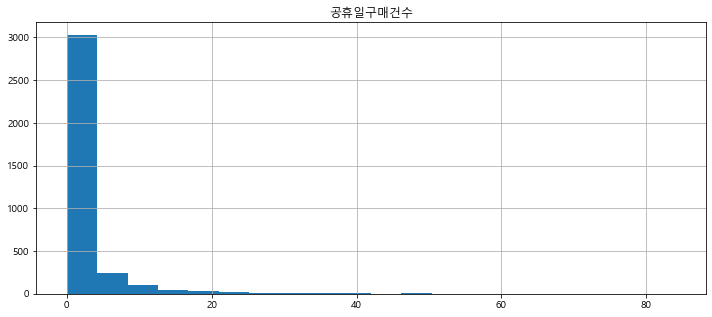

In [36]:
fig, ax = plt.subplots(figsize = (12,5))
features['공휴일구매건수'].hist(bins = 20)
plt.title('공휴일구매건수')
plt.show()

**[파생변수 34]** 행사성고객 여부

In [37]:
features['행사성고객'] = features['내점일수'].apply(lambda x: 1 if x == 1 else 0)

In [38]:
features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,주구매상품,주구매지점,남성키워드구매건수비율,여성키워드구매건수비율,명품키워드구매건수비율,행사키워드구매건수비율,영키워드구매건수비율,최다방문지점구매비율,공휴일구매건수,행사성고객
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,기타,강남점,0.054054,0.094595,0.0,0.067568,0.0,0.959459,2.0,0
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,스포츠,잠실점,0.666667,0.000000,0.0,0.000000,0.0,1.000000,0.0,0
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,기타,관악점,0.500000,0.000000,0.0,0.000000,0.0,1.000000,0.0,0
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,기타,광주점,0.000000,0.022727,0.0,0.000000,0.0,1.000000,3.0,0
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,화장품,본 점,0.000000,0.333333,0.0,0.000000,0.0,1.000000,0.0,0


http://contents.kocw.or.kr/KOCW/document/2016/cup/okjeongwon/7.pdf

**[파생변수 35]** 환불비율

In [39]:
features['환불비율'] = features['환불건수'] / features['구매건수']

In [40]:
features.head()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,주구매지점,남성키워드구매건수비율,여성키워드구매건수비율,명품키워드구매건수비율,행사키워드구매건수비율,영키워드구매건수비율,최다방문지점구매비율,공휴일구매건수,행사성고객,환불비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,강남점,0.054054,0.094595,0.0,0.067568,0.0,0.959459,2.0,0,0.040541
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,잠실점,0.666667,0.000000,0.0,0.000000,0.0,1.000000,0.0,0,0.333333
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,관악점,0.500000,0.000000,0.0,0.000000,0.0,1.000000,0.0,0,0.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,광주점,0.000000,0.022727,0.0,0.000000,0.0,1.000000,3.0,0,0.000000
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,본 점,0.000000,0.333333,0.0,0.000000,0.0,1.000000,0.0,0,0.000000


<br><font color='green'>
### Feature Correlation

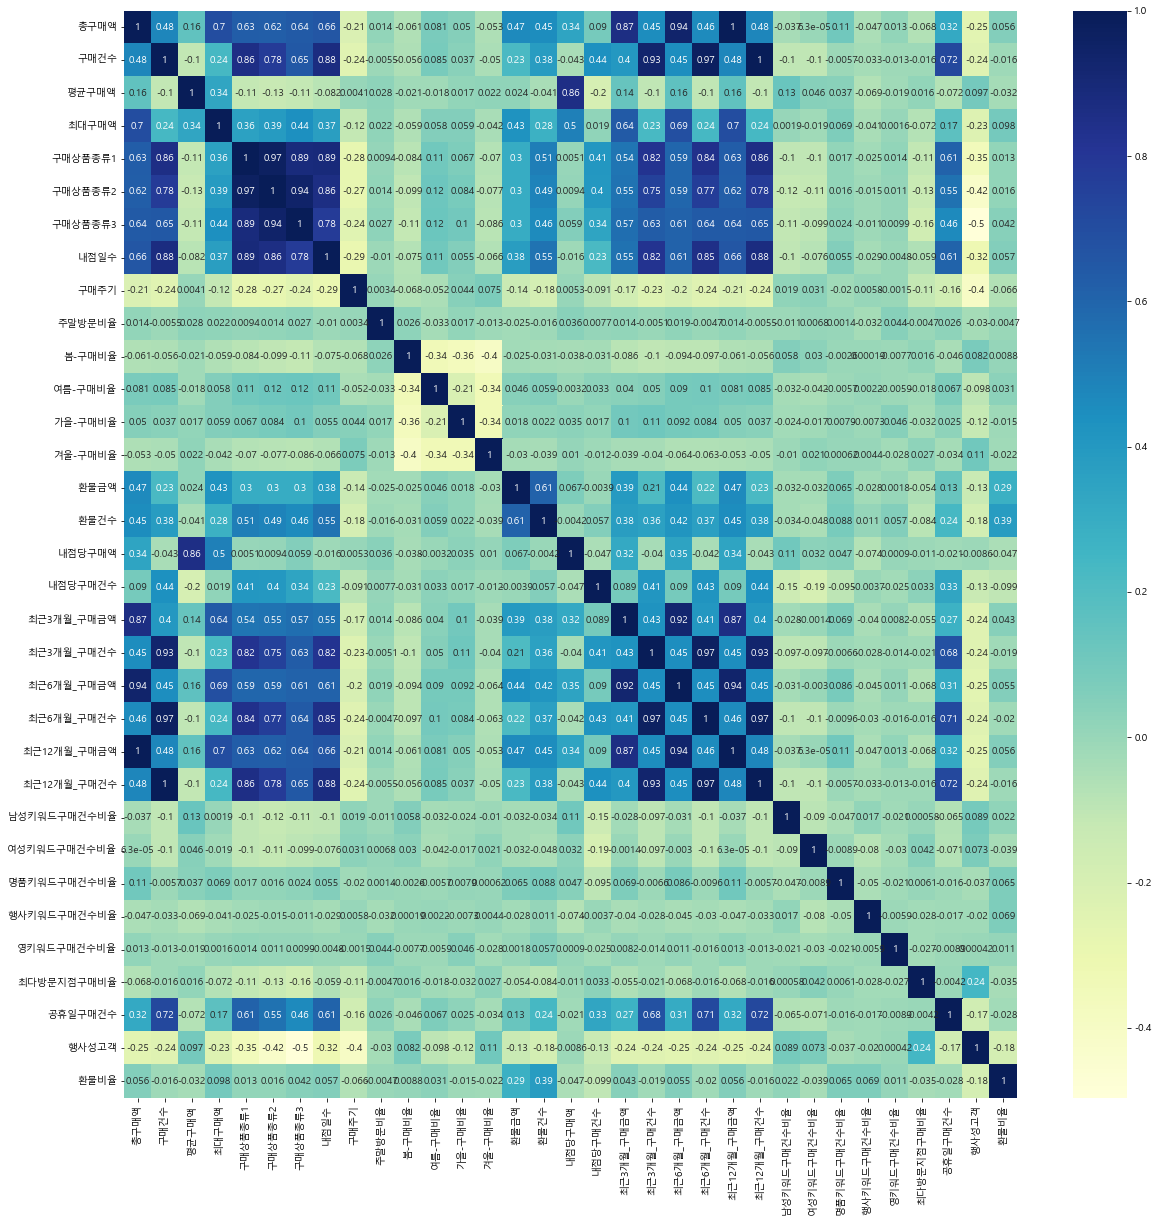

In [41]:
# 상관계수(-1 ~ +1)를 통해 feature 간의 유사성을 파악 
plt.figure(figsize=(20,20))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

## Save Features
- 아래 코드를 수행하면 생성한 모든 파생변수가 CSV 화일로 만들어진다.

In [42]:
display(features)
features.to_csv('features.csv', index=False, encoding='cp949')
features.info()

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,주구매지점,남성키워드구매건수비율,여성키워드구매건수비율,명품키워드구매건수비율,행사키워드구매건수비율,영키워드구매건수비율,최다방문지점구매비율,공휴일구매건수,행사성고객,환불비율
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,강남점,0.054054,0.094595,0.000000,0.067568,0.0,0.959459,2.0,0,0.040541
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,잠실점,0.666667,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0,0.333333
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,관악점,0.500000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0,0.000000
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,광주점,0.000000,0.022727,0.000000,0.000000,0.0,1.000000,3.0,0,0.000000
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,본 점,0.000000,0.333333,0.000000,0.000000,0.0,1.000000,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,3175200,2,1587600,3042900,1,2,2,1,0,...,본 점,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,1,0.000000
3496,3496,29628600,13,2279123,7200000,9,7,5,8,40,...,부산본점,0.076923,0.000000,0.000000,0.076923,0.0,1.000000,0.0,0,0.076923
3497,3497,75000,1,75000,75000,1,1,1,1,0,...,창원점,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.0,1,0.000000
3498,3498,1875000,2,937500,1000000,1,1,1,2,39,...,본 점,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.0,0,0.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500 entries, 0 to 3499
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cust_id      3500 non-null   int64  
 1   총구매액         3500 non-null   int64  
 2   구매건수         3500 non-null   int64  
 3   평균구매액        3500 non-null   int64  
 4   최대구매액        3500 non-null   int64  
 5   구매상품종류1      3500 non-null   int64  
 6   구매상품종류2      3500 non-null   int64  
 7   구매상품종류3      3500 non-null   int64  
 8   내점일수         3500 non-null   int64  
 9   구매주기         3500 non-null   int64  
 10  주말방문비율       3500 non-null   float64
 11  봄-구매비율       3500 non-null   float64
 12  여름-구매비율      3500 non-null   float64
 13  가을-구매비율      3500 non-null   float64
 14  겨울-구매비율      3500 non-null   float64
 15  환불금액         3500 non-null   float64
 16  환불건수         3500 non-null   float64
 17  내점당구매액       3500 non-null   float64
 18  내점당구매건수      3500 non-null   float64
 19  최근3개월_

# End